In [121]:
import pandas as pd
import numpy as np

In [ ]:
# function to apply weighted standarization as done in paper
def weigted_standarize(val, weights):
    temp_mean=np.average(val,weights=weights)
    temp_sd=np.sqrt(np.average((val-temp_mean)**2,weights=weights))
    return (val-temp_mean)/temp_sd

In [122]:
# load data
task_data = pd.read_csv("Data\\onet_tasks.csv")

isco = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name=None)
isco = {k:v.set_index('TIME').replace(':', np.nan) for k,v in isco.items()}

In [123]:
# define countries and variables to analyze
aggs = ['t_4A2a4', 't_4A2b2', 't_4A4a1']
countries = ["Poland", 'Belgium', 'Denmark']

In [124]:
# transform isco datasets, each dataset must be containing share of each isco among every isco
# divide each isco by total, add isco indicator
for k in isco:
    if k != 'Total':
        isco[k] /= isco['Total']
        isco[k]['ISCO'] = k.split('ISCO')[1]
del isco['Total']

#concat datasets, add isco to index to have multiindex 
all_data = pd.concat(isco.values())
all_data.set_index('ISCO', append=True, inplace=True)
all_data = all_data[countries]

In [125]:
# aggregate variable dataset by first digit of isco and calculate mean
aggdata = task_data.groupby(task_data["isco08"].astype(str).str[:1]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# merge share data with variables dataset in join fashion
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08', how='left')
combined.index = all_data.index

In [127]:
# for each country calculate sum of weighted standardised variables (standardised by iso weight)
# then standardise sums once again and calculate something like weighted mean on country level (agg_)
for country in all_data.columns:
    combined[country+'_NRCA'] = 0

    for agg in aggdata.columns:
        combined[country+'_NRCA'] += weigted_standarize(combined[agg], combined[country])
        
    combined['multip_'+country+'_NRCA'] = weigted_standarize(combined[country+'_NRCA'], combined[country]) * combined[country]

agg_ = combined.groupby(level=0)[[x for x in combined.columns if x.startswith('multip_')]].sum()

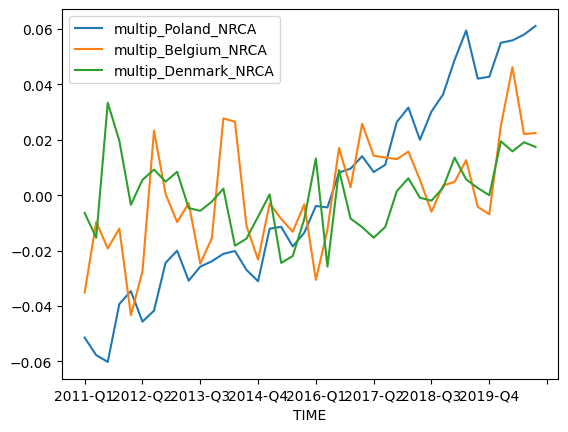

In [130]:
# plot series
agg_.plot();